In [20]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
from tensorflow.keras.preprocessing.text import Tokenizer
from keras import preprocessing
from keras.datasets import imdb
from random import shuffle
import torch

# 1. Reimplementation of Glove in Torch

In [ ]:
start_char = 1
oov_char = 2
index_from = 3

(x_train, _), _ = imdb.load_data(
    start_char=start_char, oov_char=oov_char, index_from=index_from
)

word_index = imdb.get_word_index()
inverted_word_index = dict(
    (i + index_from, word) for (word, i) in word_index.items()
)
# Update `inverted_word_index` to include `start_char` and `oov_char`
inverted_word_index[start_char] = "[START]"
inverted_word_index[oov_char] = "[OOV]"
vocab_size = max(word_index.values()) + index_from

decoded_sequence = " ".join(inverted_word_index[i] for i in x_train[0])
decoded_sequence

1641221/1641221 [==============================] - 1s 1us/step


"[START] this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and sh

In [ ]:
from tqdm import tqdm
import os

window = 10
left_window = window // 2
right_window = window - left_window

def gen_X():
    if os.path.exists('indexes.npy') and os.path.exists('X.npy'): return
    X = np.zeros((vocab_size, vocab_size), dtype=np.float32)
    indexes = set()
    for s in tqdm(x_train):
        for i in range(len(s)):
            w = s[i]
            j_indexes = np.concatenate([
                np.arange(max(0, i - left_window), i),
                np.arange(i+1, min(len(s), i + right_window + 1))])
            for j in j_indexes:
                d = 1.0 / (j - i)
                c = s[j]
                X[w, c] += d
    indexes = []
    all_idx = np.arange(vocab_size)
    for i in tqdm(range(vocab_size)):
        mask = X[i] != 0
        if np.sum(mask) == 0: continue
        for j in all_idx[mask]:
            indexes.append((i, j))

    indexes = np.array(indexes, dtype=np.int64)

    # generate f function
    np.save('X.npy', X.astype(np.float32))
    np.save('indexes.npy', indexes)

gen_X()

100%|██████████| 88587/88587 [00:16<00:00, 5375.30it/s]


In [ ]:
embedding_size = 50

In [ ]:
class Glove(torch.nn.Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.W = torch.nn.Embedding(vocab_size, embedding_size)
        self.C = torch.nn.Embedding(vocab_size, embedding_size)
        self.b_w = torch.nn.Embedding(vocab_size, 1)
        self.b_c = torch.nn.Embedding(vocab_size, 1)

    def loss(self, index, Xij, Xmax=1000, alpha=0.75):
        i = index[:, 0]
        j = index[:, 1]

        f = torch.where(Xij < Xmax, torch.pow(Xij / Xmax, alpha), 1)
        loss = f * torch.pow(
            torch.einsum('ij,ij->i', self.W(i), self.C(j)) +
            self.b_w(i) + self.b_c(j) - torch.log10(Xij + 1e-6), 2)

        return loss.mean()

In [ ]:
glove = Glove(vocab_size, embedding_size)

# load but leave vectors in disk
X = np.load('X.npy', mmap_mode='r')
indexes = np.load('indexes.npy', mmap_mode='r')

shuffle_idx = np.arange(len(indexes))
np.random.shuffle(shuffle_idx)

In [ ]:
device = 'cuda'

In [ ]:
glove = glove.to(device)

print('... done wth transferring to device')

... done wth transferring to device


In [12]:
optimizer = torch.optim.Adagrad(glove.parameters(), lr=0.005, weight_decay=0.95)

good = torch.tensor(word_index['good'] + index_from, dtype=torch.int64).to(device)
bad = torch.tensor(word_index['bad'] + index_from, dtype=torch.int64).to(device)

epochs = 50
batch_size = 8192
Xmax = 1000.0
for epoch in range(epochs):
    print('epoch', epoch)
    np.random.shuffle(shuffle_idx)
    loss_v = []
    for i in tqdm(range(0, len(shuffle_idx), batch_size)):
        index_batch = shuffle_idx[i:i+batch_size]
        index_batch = np.array([indexes[ii] for ii in index_batch])
        X_batch = np.concatenate(
            [[X[ii,jj]] for ii, jj in index_batch ]).astype(np.float32)
        X_batch = np.clip(X_batch, 0.0, Xmax)
        index_batch = torch.from_numpy(np.array(index_batch).astype(np.int64)).to(device)
        X_batch = torch.from_numpy(X_batch.astype(np.float32)).to(device)
        loss = glove.loss(index_batch, X_batch, Xmax)
        loss_v.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    good_v = glove.W(good).detach().cpu().numpy()
    bad_v = glove.W(bad).detach().cpu().numpy()
    good_v = good_v / np.linalg.norm(good_v)
    bad_v = bad_v / np.linalg.norm(bad_v)

    print(f'... {epoch}: {np.mean(loss_v)} good.bad = {np.dot(good_v, bad_v)}')


epoch 0


100%|██████████| 1405/1405 [01:54<00:00, 12.22it/s]


... 0: 0.017837328615588437 good.bad = -0.05141710489988327
epoch 1


100%|██████████| 1405/1405 [01:54<00:00, 12.31it/s]


... 1: 0.009681103145206526 good.bad = -0.06135706230998039
epoch 2


100%|██████████| 1405/1405 [01:54<00:00, 12.31it/s]


... 2: 0.006986671868459822 good.bad = -0.07291744649410248
epoch 3


100%|██████████| 1405/1405 [01:53<00:00, 12.35it/s]


... 3: 0.005566194830164048 good.bad = -0.0835118219256401
epoch 4


100%|██████████| 1405/1405 [01:53<00:00, 12.41it/s]


... 4: 0.004707724809997924 good.bad = -0.0924806222319603
epoch 5


100%|██████████| 1405/1405 [01:52<00:00, 12.45it/s]


... 5: 0.004142610494252891 good.bad = -0.09983472526073456
epoch 6


100%|██████████| 1405/1405 [01:54<00:00, 12.29it/s]


... 6: 0.003747666168633146 good.bad = -0.10578110069036484
epoch 7


100%|██████████| 1405/1405 [01:52<00:00, 12.49it/s]


... 7: 0.003461103063007134 good.bad = -0.11054706573486328
epoch 8


100%|██████████| 1405/1405 [01:52<00:00, 12.48it/s]


... 8: 0.0032470588752124925 good.bad = -0.11432695388793945
epoch 9


100%|██████████| 1405/1405 [01:52<00:00, 12.53it/s]


... 9: 0.003084179143308665 good.bad = -0.11727575212717056
epoch 10


100%|██████████| 1405/1405 [01:52<00:00, 12.50it/s]


... 10: 0.002965748696455407 good.bad = -0.11951585114002228
epoch 11


100%|██████████| 1405/1405 [01:53<00:00, 12.34it/s]


... 11: 0.002856559238605387 good.bad = -0.12114124000072479
epoch 12


100%|██████████| 1405/1405 [01:53<00:00, 12.34it/s]


... 12: 0.0027747597970860577 good.bad = -0.12222795933485031
epoch 13


100%|██████████| 1405/1405 [01:55<00:00, 12.20it/s]


... 13: 0.002708969816144596 good.bad = -0.12283991277217865
epoch 14


100%|██████████| 1405/1405 [01:52<00:00, 12.46it/s]


... 14: 0.0026542825379501696 good.bad = -0.12302873283624649
epoch 15


100%|██████████| 1405/1405 [01:53<00:00, 12.37it/s]


... 15: 0.0026098789604964046 good.bad = -0.122840516269207
epoch 16


100%|██████████| 1405/1405 [01:53<00:00, 12.42it/s]


... 16: 0.0025750078403414143 good.bad = -0.12231656908988953
epoch 17


100%|██████████| 1405/1405 [01:53<00:00, 12.41it/s]


... 17: 0.002539155047695116 good.bad = -0.12149050831794739
epoch 18


100%|██████████| 1405/1405 [01:52<00:00, 12.49it/s]


... 18: 0.002517593748373679 good.bad = -0.12039638310670853
epoch 19


100%|██████████| 1405/1405 [01:52<00:00, 12.53it/s]


... 19: 0.0024889916803827014 good.bad = -0.1190631240606308
epoch 20


100%|██████████| 1405/1405 [01:52<00:00, 12.50it/s]


... 20: 0.002468706099183905 good.bad = -0.11751902103424072
epoch 21


100%|██████████| 1405/1405 [01:52<00:00, 12.52it/s]


... 21: 0.002451382921320913 good.bad = -0.11578907072544098
epoch 22


100%|██████████| 1405/1405 [01:52<00:00, 12.53it/s]


... 22: 0.002437168973153358 good.bad = -0.11404676735401154
epoch 23


100%|██████████| 1405/1405 [01:53<00:00, 12.35it/s]


... 23: 0.002423067685519925 good.bad = -0.11186254024505615
epoch 24


100%|██████████| 1405/1405 [01:54<00:00, 12.23it/s]


... 24: 0.002412320767550852 good.bad = -0.10970789939165115
epoch 25


100%|██████████| 1405/1405 [01:55<00:00, 12.19it/s]


... 25: 0.002400850065531428 good.bad = -0.10745076835155487
epoch 26


100%|██████████| 1405/1405 [01:53<00:00, 12.34it/s]


... 26: 0.002391798655855473 good.bad = -0.10510753840208054
epoch 27


100%|██████████| 1405/1405 [01:53<00:00, 12.38it/s]


... 27: 0.002384236018965518 good.bad = -0.10269573330879211
epoch 28


100%|██████████| 1405/1405 [01:53<00:00, 12.40it/s]


... 28: 0.0023765027639456094 good.bad = -0.10022816807031631
epoch 29


100%|██████████| 1405/1405 [01:53<00:00, 12.38it/s]


... 29: 0.0023728169937903107 good.bad = -0.09771904349327087
epoch 30


100%|██████████| 1405/1405 [01:52<00:00, 12.50it/s]


... 30: 0.00236455253275688 good.bad = -0.09517889469861984
epoch 31


100%|██████████| 1405/1405 [01:53<00:00, 12.37it/s]


... 31: 0.0023586588701253156 good.bad = -0.09262113273143768
epoch 32


100%|██████████| 1405/1405 [01:53<00:00, 12.38it/s]


... 32: 0.0023556706053950555 good.bad = -0.09005355089902878
epoch 33


100%|██████████| 1405/1405 [01:53<00:00, 12.36it/s]


... 33: 0.002349722152037274 good.bad = -0.08748608827590942
epoch 34


100%|██████████| 1405/1405 [01:52<00:00, 12.52it/s]


... 34: 0.002347199529288436 good.bad = -0.08492661267518997
epoch 35


100%|██████████| 1405/1405 [01:51<00:00, 12.55it/s]


... 35: 0.0023442163959881326 good.bad = -0.08238228410482407
epoch 36


100%|██████████| 1405/1405 [01:51<00:00, 12.59it/s]


... 36: 0.0023395135704580416 good.bad = -0.07985926419496536
epoch 37


100%|██████████| 1405/1405 [01:51<00:00, 12.55it/s]


... 37: 0.0023365589397299864 good.bad = -0.07736364752054214
epoch 38


100%|██████████| 1405/1405 [01:53<00:00, 12.33it/s]


... 38: 0.0023354407592123087 good.bad = -0.07490044087171555
epoch 39


100%|██████████| 1405/1405 [01:53<00:00, 12.34it/s]


... 39: 0.002332440777590624 good.bad = -0.07247332483530045
epoch 40


100%|██████████| 1405/1405 [01:51<00:00, 12.56it/s]


... 40: 0.0023295586311019743 good.bad = -0.07008691132068634
epoch 41


100%|██████████| 1405/1405 [01:51<00:00, 12.59it/s]


... 41: 0.0023297041675715553 good.bad = -0.06774386018514633
epoch 42


100%|██████████| 1405/1405 [01:52<00:00, 12.51it/s]


... 42: 0.002325307230715345 good.bad = -0.06544791907072067
epoch 43


100%|██████████| 1405/1405 [01:52<00:00, 12.52it/s]


... 43: 0.0023237457473636387 good.bad = -0.06319993734359741
epoch 44


100%|██████████| 1405/1405 [01:52<00:00, 12.50it/s]


... 44: 0.0023230979108878036 good.bad = -0.061002690345048904
epoch 45


100%|██████████| 1405/1405 [01:52<00:00, 12.52it/s]


... 45: 0.002321531707039799 good.bad = -0.05885590612888336
epoch 46


100%|██████████| 1405/1405 [01:51<00:00, 12.56it/s]


... 46: 0.002319020790493719 good.bad = -0.05675984174013138
epoch 47


100%|██████████| 1405/1405 [01:53<00:00, 12.39it/s]


... 47: 0.002318121832290008 good.bad = -0.05472559481859207
epoch 48


100%|██████████| 1405/1405 [01:55<00:00, 12.14it/s]


... 48: 0.002316872783011866 good.bad = -0.05274204909801483
epoch 49


100%|██████████| 1405/1405 [01:54<00:00, 12.27it/s]


... 49: 0.002318652170160089 good.bad = -0.050813235342502594
epoch 50


100%|██████████| 1405/1405 [01:54<00:00, 12.30it/s]


... 50: 0.002317527724178077 good.bad = -0.04893956705927849
epoch 51


100%|██████████| 1405/1405 [01:53<00:00, 12.40it/s]


... 51: 0.00231343164428525 good.bad = -0.04711981862783432
epoch 52


100%|██████████| 1405/1405 [01:53<00:00, 12.35it/s]


... 52: 0.0023152320239745957 good.bad = -0.045354750007390976
epoch 53


100%|██████████| 1405/1405 [01:54<00:00, 12.28it/s]


... 53: 0.0023139435863801776 good.bad = -0.043643999844789505
epoch 54


100%|██████████| 1405/1405 [01:53<00:00, 12.40it/s]


... 54: 0.002311204961713178 good.bad = -0.041987109929323196
epoch 55


100%|██████████| 1405/1405 [01:52<00:00, 12.50it/s]


... 55: 0.0023102534240943603 good.bad = -0.04038212075829506
epoch 56


100%|██████████| 1405/1405 [01:51<00:00, 12.57it/s]


... 56: 0.002315365218804334 good.bad = -0.03883051499724388
epoch 57


100%|██████████| 1405/1405 [01:52<00:00, 12.46it/s]


... 57: 0.002314567061727767 good.bad = -0.037329599261283875
epoch 58


100%|██████████| 1405/1405 [01:52<00:00, 12.47it/s]


... 58: 0.002308352235137084 good.bad = -0.035879138857126236
epoch 59


100%|██████████| 1405/1405 [01:53<00:00, 12.38it/s]


... 59: 0.0023092258290729065 good.bad = -0.03447742760181427
epoch 60


100%|██████████| 1405/1405 [01:53<00:00, 12.38it/s]


... 60: 0.0023082542178482876 good.bad = -0.03312429413199425
epoch 61


100%|██████████| 1405/1405 [01:54<00:00, 12.30it/s]


... 61: 0.002307510680727846 good.bad = -0.031818706542253494
epoch 62


100%|██████████| 1405/1405 [01:53<00:00, 12.43it/s]


... 62: 0.002308912649112704 good.bad = -0.030558999627828598
epoch 63


100%|██████████| 1405/1405 [01:52<00:00, 12.51it/s]


... 63: 0.0023062361008239067 good.bad = -0.029344217851758003
epoch 64


100%|██████████| 1405/1405 [01:52<00:00, 12.51it/s]


... 64: 0.00230549033874152 good.bad = -0.028173530474305153
epoch 65


100%|██████████| 1405/1405 [01:52<00:00, 12.52it/s]


... 65: 0.0023067553216107586 good.bad = -0.027044950053095818
epoch 66


100%|██████████| 1405/1405 [01:52<00:00, 12.54it/s]


... 66: 0.002305030974798117 good.bad = -0.025958485901355743
epoch 67


100%|██████████| 1405/1405 [01:52<00:00, 12.45it/s]


... 67: 0.0023046267016714576 good.bad = -0.024911580607295036
epoch 68


100%|██████████| 1405/1405 [01:54<00:00, 12.24it/s]


... 68: 0.0023045199960089052 good.bad = -0.02390354685485363
epoch 69


100%|██████████| 1405/1405 [01:53<00:00, 12.36it/s]


... 69: 0.0023041728705422973 good.bad = -0.02293369732797146
epoch 70


100%|██████████| 1405/1405 [01:52<00:00, 12.45it/s]


... 70: 0.002305346013674864 good.bad = -0.022000597789883614
epoch 71


100%|██████████| 1405/1405 [01:53<00:00, 12.36it/s]


... 71: 0.0023034482449873143 good.bad = -0.02110276184976101
epoch 72


100%|██████████| 1405/1405 [01:53<00:00, 12.42it/s]


... 72: 0.002306539847787297 good.bad = -0.020239224657416344
epoch 73


100%|██████████| 1405/1405 [01:52<00:00, 12.46it/s]


... 73: 0.002302877385678015 good.bad = -0.019408877938985825
epoch 74


100%|██████████| 1405/1405 [01:53<00:00, 12.35it/s]


... 74: 0.0023029866651134746 good.bad = -0.01861134171485901
epoch 75


100%|██████████| 1405/1405 [01:52<00:00, 12.45it/s]


... 75: 0.0023084655225946438 good.bad = -0.01784469000995159
epoch 76


100%|██████████| 1405/1405 [01:52<00:00, 12.54it/s]


... 76: 0.0023024486114761504 good.bad = -0.017107224091887474
epoch 77


100%|██████████| 1405/1405 [01:51<00:00, 12.58it/s]


... 77: 0.002302397359900004 good.bad = -0.016399677842855453
epoch 78


100%|██████████| 1405/1405 [01:51<00:00, 12.61it/s]


... 78: 0.0023029013616828334 good.bad = -0.01571941375732422
epoch 79


100%|██████████| 1405/1405 [01:51<00:00, 12.61it/s]


... 79: 0.0023034409639753695 good.bad = -0.01506621390581131
epoch 80


100%|██████████| 1405/1405 [01:51<00:00, 12.54it/s]


... 80: 0.002301773627112981 good.bad = -0.014438707381486893
epoch 81


100%|██████████| 1405/1405 [01:54<00:00, 12.29it/s]


... 81: 0.002301709319910638 good.bad = -0.013836611062288284
epoch 82


100%|██████████| 1405/1405 [01:53<00:00, 12.38it/s]


... 82: 0.002301673684932053 good.bad = -0.013258478604257107
epoch 83


100%|██████████| 1405/1405 [01:51<00:00, 12.62it/s]


... 83: 0.0023032215875457454 good.bad = -0.012704647146165371
epoch 84


100%|██████████| 1405/1405 [01:52<00:00, 12.52it/s]


... 84: 0.0023027053320767137 good.bad = -0.012171761132776737
epoch 85


100%|██████████| 1405/1405 [01:52<00:00, 12.53it/s]


... 85: 0.0023014430878882785 good.bad = -0.011660872958600521
epoch 86


100%|██████████| 1405/1405 [01:52<00:00, 12.46it/s]


... 86: 0.0023006745377552175 good.bad = -0.011171514168381691
epoch 87


100%|██████████| 1405/1405 [01:52<00:00, 12.49it/s]


... 87: 0.0023014024952741413 good.bad = -0.010700934566557407
epoch 88


100%|██████████| 1405/1405 [01:52<00:00, 12.51it/s]


... 88: 0.0023006376726271128 good.bad = -0.010249924845993519
epoch 89


100%|██████████| 1405/1405 [01:52<00:00, 12.45it/s]


... 89: 0.0023004476208441965 good.bad = -0.009818275459110737
epoch 90


100%|██████████| 1405/1405 [01:52<00:00, 12.44it/s]


... 90: 0.0023003527336568305 good.bad = -0.00940278172492981
epoch 91


100%|██████████| 1405/1405 [01:52<00:00, 12.48it/s]


... 91: 0.0023016482545228614 good.bad = -0.00900565180927515
epoch 92


100%|██████████| 1405/1405 [01:53<00:00, 12.36it/s]


... 92: 0.002300056377533505 good.bad = -0.008624304085969925
epoch 93


100%|██████████| 1405/1405 [01:53<00:00, 12.42it/s]


... 93: 0.0022999641812800884 good.bad = -0.008258437737822533
epoch 94


100%|██████████| 1405/1405 [01:55<00:00, 12.21it/s]


... 94: 0.0023002110123783483 good.bad = -0.007908079773187637
epoch 95


100%|██████████| 1405/1405 [01:53<00:00, 12.34it/s]


... 95: 0.002300494339680001 good.bad = -0.007572588045150042
epoch 96


100%|██████████| 1405/1405 [01:54<00:00, 12.32it/s]


... 96: 0.0023002220642524256 good.bad = -0.007250547409057617
epoch 97


100%|██████████| 1405/1405 [01:56<00:00, 12.08it/s]


... 97: 0.0023005931670495782 good.bad = -0.006942203268408775
epoch 98


100%|██████████| 1405/1405 [01:53<00:00, 12.35it/s]


... 98: 0.002300561845610813 good.bad = -0.006645638030022383
epoch 99


100%|██████████| 1405/1405 [01:54<00:00, 12.28it/s]

... 99: 0.002300975344755299 good.bad = -0.006362037267535925


In [13]:
good = torch.tensor(word_index['good'] + index_from, dtype=torch.int64).to(device)
bad = torch.tensor(word_index['bad'] + index_from, dtype=torch.int64).to(device)

good_v = glove.W(good).detach().cpu().numpy()
bad_v = glove.W(bad).detach().cpu().numpy()
good_v = good_v / np.linalg.norm(good_v)
bad_v = bad_v / np.linalg.norm(bad_v)

np.dot(good_v, bad_v)

-0.0063620373

Now explain with your own words how Glove works.  Find which word is a synonym for `positive` and an antonym for `positive`.

GloVe works by creating a global co-occurrence matrix and using a log-bilinear regression model to get relationships between words. The model uses both global statistical information and local context, creating word vectors that are great in capturing semantic and syntactic patterns in text.

Good is the synonym for positive, and bad is the antonym for positive.

# 2. Second Attempt to Build a Large Language Model

In an attempt to create our first generator network before we start using transformers, you will build a large language model using a Convolutional (causal) and Embeddings.

We will split this task into two task.

- Task is to try to predict the next word.


In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import string
import os
import pandas as pd
import numpy as np

In [2]:
class Tokenizer:
    def __init__(self):
        self.chars = ['\00', '\01'] + sorted(list(set(string.printable)))
        self.vocab_size = len(self.chars)
        self.stoi = { ch:i for i,ch in enumerate(self.chars) }
        self.itos = { i:ch for i,ch in enumerate(self.chars) }

        self.itos[0] = '[START]'
        self.itos[1] = '[OOV]'

    def encode(self, sentence):
        return [self.stoi[c] if c in self.stoi else 1 for c in sentence]

    def decode(self, indexes):
        return [self.itos[i] for i in indexes]

    def start(self): return '\00'

    def oov(self): return '\01'

tokenizer = Tokenizer()
print(tokenizer.encode('hello world'))
print(tokenizer.decode([0] + [1] + tokenizer.encode('\x96hello world')))

[79, 76, 83, 83, 86, 7, 94, 86, 89, 83, 75]
['[START]', '[OOV]', '[OOV]', 'h', 'e', 'l', 'l', 'o', ' ', 'w', 'o', 'r', 'l', 'd']


In [3]:
def process_songs(df):
    songs = tokenizer.start().join(df.text.to_numpy())
    songs = tokenizer.start() + songs.replace('\r', '', -1)
    return tokenizer.encode(songs)

In [4]:
# Download the song dataset from
# https://www.kaggle.com/datasets/notshrirang/spotify-million-song-dataset

In [7]:
from google.colab import files


uploaded = files.upload()

Saving spotify_millsongdata.csv to spotify_millsongdata.csv


In [8]:
import pandas as pd
import io

df = pd.read_csv('spotify_millsongdata.csv')
#df = pd.read_csv(io.BytesIO(uploaded['spotify_millsongdata.csv']))
print(len(df), 'songs')

57650 songs


In [11]:
!pip install tiktoken


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.3 MB/s eta 0:00:00


In [12]:
import tiktoken
tokenizer_gpt2 = tiktoken.get_encoding('gpt2')
tokenizer_gpt2.n_vocab

50257

In [13]:
if not os.path.exists('spotify_x_train.bin') or not os.path.exists('spotify_x_test.bin'):
    train_size = int(len(df) * 0.9)
    x_train = process_songs(df.iloc[:train_size])
    x_test = process_songs(df.iloc[train_size:])
    assert np.max(x_train) < 256
    print(len(x_train), len(x_test))

    x_train = np.array(x_train, dtype=np.uint8)
    x_test = np.array(x_test, dtype=np.uint8)

    x_train.tofile('spotify_x_train.bin')
    x_test.tofile('spotify_x_test.bin')

61025756 7030351


In [14]:
# we will use mmap to reduce memory in this jupyter notebook
x_train = np.memmap('spotify_x_train.bin', dtype=np.uint8, mode='r')
x_test = np.memmap('spotify_x_test.bin', dtype=np.uint8, mode='r')

In [15]:
df.text.apply(len).min(), df.text.apply(len).max()

(410, 4186)

In [16]:
len(df.artist.unique())

643

In [17]:
# this code is derived from nanogpt (https://github.com/karpathy/nanoGPT)

class CausalSelfAttention(nn.Module):
    def __init__(self, transformers_size, n_heads, dropout,
                 max_seqlen, bias):
        super().__init__()
        assert transformers_size % n_heads == 0
        self.c_attn = nn.Linear(
                transformers_size, 3 * transformers_size, bias=bias)
        # output projection
        self.c_proj = nn.Linear(transformers_size,
                                transformers_size, bias=bias)
        # regularization
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)
        self.n_heads = n_heads
        self.transformers_size = transformers_size
        self.dropout = dropout

        self.register_buffer(
            "bias", torch.tril(torch.ones(max_seqlen, max_seqlen))
            .view(1, 1, max_seqlen, max_seqlen))

    def forward(self, x):
        B, T, C = x.size()

        # calculate query, key, values for all heads in batch
        # and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.transformers_size, dim=2)
        # (B, nh, T, hs)
        k = k.view(B, T, self.n_heads, C // self.n_heads).transpose(1, 2)
        q = q.view(B, T, self.n_heads, C // self.n_heads).transpose(1, 2)
        v = v.view(B, T, self.n_heads, C // self.n_heads).transpose(1, 2)

        # causal self-attention; Self-attend:
        #     (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        # manual implementation of attention
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        # re-assemble all head outputs side by side
        y = y.transpose(1, 2).contiguous().view(B, T, C)

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

class FeedForward(nn.Module):
    def __init__(self, transformers_size, dropout, bias=False):
        super().__init__()
        n = 4
        self.c_fc    = nn.Linear(
            transformers_size, n * transformers_size, bias=bias)
        self.c_proj  = nn.Linear(
            n * transformers_size, transformers_size, bias=bias)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = nn.GELU(approximate='tanh')(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):
    def __init__(
            self, transformers_size, num_heads, dropout,
            max_seqlen, bias=False):
        super().__init__()
        self.ln_1 = nn.LayerNorm(transformers_size)
        self.attn = CausalSelfAttention(
            transformers_size, num_heads, dropout, max_seqlen, bias=bias)
        self.ln_2 = nn.LayerNorm(transformers_size)
        self.mlp = FeedForward(transformers_size, dropout, bias)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

class LLM(nn.Module):
    def __init__(self, n_layers, num_heads, embedding_size, vocab_size, max_seqlen, dropout):
        super().__init__()
        self.max_seqlen = max_seqlen
        self.wte = nn.Embedding(vocab_size, embedding_size)
        self.wpe = nn.Embedding(max_seqlen, embedding_size)
        self.dropout = nn.Dropout(dropout)
        self.blocks = nn.ModuleList([
            Block(embedding_size, num_heads, dropout, max_seqlen, bias=True)
            for _ in range(n_layers)
        ])
        self.ln_f = nn.LayerNorm(embedding_size)
        self.lm_head = nn.Linear(
            embedding_size, vocab_size, bias=False)

        # from GPT2 / nanoGPT

        self.wte.weight = self.lm_head.weight
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(
                    p, mean=0.0, std=0.02/math.sqrt(2 * n_layers))

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
        """
        This long function is unfortunately doing something very simple
        and is being very defensive:
        We are separating out all parameters of the model into two buckets:
        those that will experience weight decay for regularization and those
        that won't (biases, and layernorm/embedding weights).
        We are then returning the PyTorch optimizer object.
        """

        # separate out all parameters to those that will and won't
        # experience regularizing weight decay
        decay = set()
        no_decay = set()
        whitelist_weight_modules = (torch.nn.Linear, torch.nn.Conv1d)
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = '%s.%s' % (mn, pn) if mn else pn # full param name
                # random note: because named_modules and named_parameters
                # are recursive we will see the same tensors p many many
                # times. but doing it this way allows us to know which
                # parent module any tensor p belongs to...
                if pn.endswith('bias'):
                    # all biases will not be decayed
                    no_decay.add(fpn)
                elif (
                    pn.endswith('weight') and
                    isinstance(m, whitelist_weight_modules)):
                    # weights of whitelist modules will be weight decayed
                    decay.add(fpn)
                elif (
                    pn.endswith('weight') and
                    isinstance(m, blacklist_weight_modules)):

                    # weights of blacklist modules will NOT be weight decayed
                    no_decay.add(fpn)

        # subtle: 'transformer.wte.weight' and 'lm_head.weight' are tied,
        # so they will appear in the no_decay and decay sets respectively
        # after the above.
        # In addition, because named_parameters() doesn't return duplicates,
        # it will only return the first occurence, key'd by
        # 'transformer.wte.weight', below. so let's manually remove
        # 'lm_head.weight' from decay set. This will include
        # this tensor into optimization via transformer.wte.weight only,
        # and not decayed.
        decay.remove('lm_head.weight')

        # validate that we considered every parameter
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay
        assert len(inter_params) == 0, (
            f"parameters {str(inter_params)} made into " +
            "both decay/no_decay sets!")
        assert len(param_dict.keys() - union_params) == 0, (
            f"parameters {str(param_dict.keys() - union_params)} were not " +
            "separated into either decay/no_decay set!")

        # create the pytorch optimizer object
        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))],
             "weight_decay": weight_decay},
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))],
             "weight_decay": 0.0},
        ]
        optimizer = torch.optim.AdamW(
            optim_groups, lr=learning_rate, betas=betas)

        return optimizer

    def forward(self, idx, targets=None, only_head=False):
        device = idx.device
        B, T = idx.shape

        assert T <= self.max_seqlen

        tok_emb = self.wte(idx) # (B, T, C)

        B, T, C = tok_emb.shape

        pos = torch.arange(
            0, T, dtype=torch.long, device=device).unsqueeze(0)
        pos_emb = self.wpe(pos)
        x = self.dropout(tok_emb + pos_emb)
        for block in self.blocks:
            x = block(x)

        x = self.ln_f(x)

        if only_head:
            return x

        if targets is not None:
            logits = self.lm_head(x)
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
        else:
            logits = self.lm_head(x[:, [-1], :])
            loss = None

        return logits, loss

In [18]:
max_seqlen = 1024
emb_size = 240
n_layers = 6
num_heads = 6
vocab_size = tokenizer.vocab_size
vocab_size

102

In [27]:
device = 'cpu'

model = LLM(n_layers=n_layers, num_heads=num_heads, embedding_size=emb_size,
            vocab_size=vocab_size, max_seqlen=max_seqlen,
            dropout=0.2)

model = model.to(device)

n_params = sum(p.numel() for n, p in model.named_parameters() if p.requires_grad)
f'{n_params // 1000}K parameters (including embeddings)'

'4436K parameters (including embeddings)'

In [22]:
batch_size = 32

loss_f = F.cross_entropy

def get_batch(data):
    ix = torch.randint(len(data) - max_seqlen, (batch_size,))
    x = torch.stack([
        torch.from_numpy(data[i:i+max_seqlen].astype(np.int64)) for i in ix])
    y = torch.stack([
        torch.from_numpy(data[i+1:i+max_seqlen+1].astype(np.int64)) for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss(x_train, x_test, eval_iters=100):
    def _internal(model):
        dataset = {'train': x_train, 'val': x_test}
        out = {}
        model.eval()
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch(dataset[split])
                p, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
        model.train()
        return out
    return _internal


In [23]:
x1, y1 = get_batch(x_train)
x1[0][:10], y1[0][:10]

(tensor([86, 85, 76, 96,  7, 89, 92, 85, 90,  7], device='cuda:0'),
 tensor([85, 76, 96,  7, 89, 92, 85, 90,  7, 86], device='cuda:0'))

In [24]:
import math

def get_lr_func(warmup_iters, learning_rate, lr_decay_iters,  min_lr):
    def __get_lr__(it):
        nonlocal decay_ratio
        # 1) linear warmup for warmup_iters steps
        if it < warmup_iters:
            return learning_rate * it / warmup_iters
        # 2) if it > lr_decay_iters, return min learning rate
        if it > lr_decay_iters:
            return min_lr
        # 3) in between, use cosine decay down to min learning rate
        decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
        assert 0 <= decay_ratio <= 1
        coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio)) # coeff ranges 0..1
        return min_lr + coeff * (learning_rate - min_lr)

    decay_ratio = 0
    return __get_lr__

learning_rate = 0.002
get_lr = get_lr_func(1000, learning_rate, 100000, learning_rate/10)

In [25]:
iter_num = 0
logs = []

In [28]:
epochs = 100

estimate_loss_f = estimate_loss(x_train, x_test, eval_iters=100)

optimizer = model.configure_optimizers(
    weight_decay=1e-1, learning_rate=learning_rate, betas=(0.9, 0.95), device_type=device)

for iter_num in range(iter_num, iter_num + epochs):
    learning_rate = get_lr(iter_num)
    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate

    if iter_num % 10 == 0:
        losses = estimate_loss_f(model)
        print(
            f'step {iter_num}: train loss {losses["train"]:.4f}, '
            f'val loss {losses["val"]:.4f}')
        logs.append((iter_num, losses['train'], losses['val']))

    xb, yb = get_batch(x_train)
    pb, loss = model(xb, yb)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()


step 0: train loss 4.5969, val loss 4.5982
step 10: train loss 3.9420, val loss 3.9426
step 20: train loss 3.6093, val loss 3.6111
step 30: train loss 3.4856, val loss 3.4865
step 40: train loss 3.3050, val loss 3.3067
step 50: train loss 3.0905, val loss 3.0921
step 60: train loss 2.9131, val loss 2.9152
step 70: train loss 2.7858, val loss 2.7909
step 80: train loss 2.6870, val loss 2.6895
step 90: train loss 2.6149, val loss 2.6151


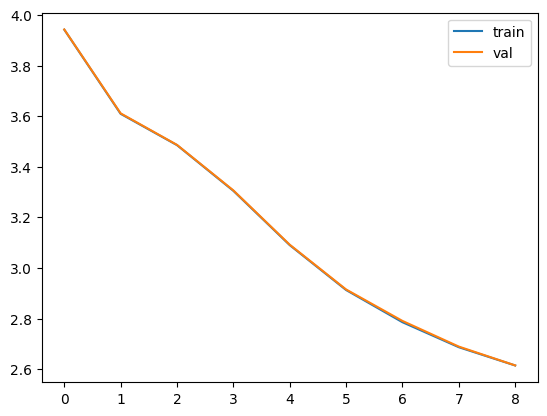

In [29]:
plt.plot([v[1] for v in logs][1:], label='train')
plt.plot([v[2] for v in logs][1:], label='val')
plt.legend()
plt.show()

In [30]:
x_test[0:20]

memmap([ 0, 48, 14, 84,  7, 85, 86, 91,  7, 90, 91, 86, 85, 76, 75,  7,
        73, 92, 91,  7], dtype=uint8)

In [31]:
print(''.join(tokenizer.decode(x_test[0:20])))

[START]I'm not stoned but 


In [32]:
@torch.no_grad()
def generate(idx, max_new_tokens, top_k=None):
    for _ in range(max_new_tokens):
        idx_cond = idx if idx.size(1) <= max_seqlen else idx[:, -max_seqlen:]
        logits, _ = model(idx_cond)
        logits = logits[:, -1, :]
        if top_k is not None:
            v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
            logits[logits < v[:, [-1]]] = -float('Inf')
        probs = F.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        if idx_next == 0: break
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [33]:
idx = torch.from_numpy(np.array([x_test[0:20]]).astype(np.int64))
result = generate(idx.to(device), max_new_tokens=1024, top_k=10).detach().cpu().numpy()
result

array([[ 0, 48, 14, ..., 91,  7,  3]])

In [34]:
decoded_sequence = ''.join(tokenizer.decode(result[0]))
print(decoded_sequence)

[START]I'm not stoned but 
Tharisthoreser  s  thou'th ow are  tt 
Blo  tss  t tin  t atitong 
Sit ttout ineloundshthe titoutithan 
Isisotasoverss t meto llothistelitr  athestoutheatores mo 
Anin ayonss t melisig 
Al   isie thonghellsid  arenowlo  t myesthet 
 totheris wnat ai 
I'l s i 
But 
Trethed w t  
or wate atisout 
I  me tot  bo t ailde  milthe in'sh  thery ser ouse w s 
Bu woudthe aresinin's  thyout  wart  me o om irind seara 
T s   y 
Wonor  
Anon 
Whoure  
So   wrs  
   
Chantomer tharyot you 
Bertisese ytre ay  isst 
I t t w assingalleeaindthat  tothe 
Aca 
I tthinow omyto theyome ishome oo ain a 
Ane s ame s 
Yo thes  willld ilino sindet   
Ware mere lollo at t w  
Andhete 
Ane ythe 
I 
 s   m 
 t me   
Ighe sigon t 
As 
 it he tondostl   s 
as thand ths aysththe 
Wo lina than we h an    
 
 s sourey   s 
I lyouris y tli m 
T s the 
Angontim 
  osot andre  yt  ile t sout 
Ise yandit y ien meaid  at walir itine  to yang me 
Arte  
 
Aninoura tt mat t  
I  n tend te waron 
I's